In [1]:
KERAS_MODELS_ABSOLUTE_PATH = '/content/gdrive/My Drive/2ecnn47'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install -qq tensorflow-datasets -U
!tfds --version

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
TensorFlow Datasets: 4.4.0


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)
plt.rc('figure', figsize=(13, 4))

2.6.0


In [5]:
if not tf.io.gfile.exists(KERAS_MODELS_ABSOLUTE_PATH):
  print('You should create', KERAS_MODELS_ABSOLUTE_PATH, 'directory manually')
  assert False

In [6]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.20.145.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.20.145.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [7]:
train_dataset, test_dataset, valid_dataset = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-musan-1.appspot.com',
    as_supervised=True, try_gcs=True)
train_dataset.cardinality().numpy()

1825800

In [8]:
train_dataset = train_dataset.map(lambda x, y: (x[1:-1], y))
test_dataset  = test_dataset.map(lambda x, y:  (x[1:-1], y))
valid_dataset = valid_dataset.map(lambda x, y: (x[1:-1], y))

In [9]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [10]:
def build_model(in_shape, activation, pooling, out_shape, *in_steps):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  x_in = keras.Input(shape=in_shape)

  x = x_in = keras.Input(shape=in_shape)

  for i in in_steps:
    x = keras.layers.Conv1D(i, 1, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = activation()(x)
    x = keras.layers.SpatialDropout1D(i / 640)(x)

  for i in range(4)[::-1]:
    r = keras.layers.Conv1D(x.shape[-1], 3, padding='same', use_bias=False)(x)
    r = keras.layers.BatchNormalization()(r)
    r = activation()(r)
    r = keras.layers.SpatialDropout1D(0.2)(r)
    r = keras.layers.Conv1D(x.shape[-1], 2, padding='same', use_bias=False)(r)
    r = keras.layers.BatchNormalization()(r)
    x = keras.layers.add([r, x])
    x = activation()(x)
    x = keras.layers.SpatialDropout1D(0.2)(x)
    x = pooling(2 if i else x.shape[1], padding='same')(x)

  x = keras.layers.Flatten()(x)

  for i in x.shape[-1] * np.array([2, 1]):
    x = keras.layers.Dense(i, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = activation()(x)
    x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Dense(out_shape)(x)
  return keras.Model(inputs=x_in, outputs=x, name='first_ensemble')

In [11]:
def build_ensemble(builders=None, models=None, activation=None):
  in_shape = (47, 13)
  if models:
    x_in = keras.Input(shape=in_shape)
    x = [keras.Model(m.inputs, m.outputs) for m in models]
    x = [e(x_in) for e in x]
    if activation:
      x = [keras.layers.Activation(activation)(e) for e in x]
      x = keras.layers.Average()(x)
    else:
      b, c = x
      b = tf.squeeze(b, -1)
      b = tf.greater(b, 2) # threshold
      u = tf.greater(c[:,10], c[:,11])
      u = tf.where(u, 10, 11)
      x = tf.where(b, tf.argmax(c, -1, u.dtype), u)
      x = tf.one_hot(x, 12)
    return keras.Model(x_in, x)
  else:
    return tuple(b(in_shape, *a) for b, *a in builders)

In [12]:
ensemble_models = (
  (build_model, keras.layers.LeakyReLU, keras.layers.MaxPool1D, 1,     128),
  (build_model, keras.layers.ReLU,      keras.layers.AvgPool1D, 1,     128),
  (build_model, keras.layers.PReLU,     keras.layers.MaxPool1D, 1, 64, 128),
  (build_model, keras.layers.ELU,       keras.layers.AvgPool1D, 1, 64, 128),
)
ensemble_models = build_ensemble(builders=ensemble_models)

In [13]:
def train_model(model, loss, train_dataset, valid_dataset):

  with strategy.scope():
    tpu_model = keras.Model.from_config(model.get_config())
    tpu_model.compile(
      loss=loss(from_logits=True),
      optimizer=keras.optimizers.Adam(),
      metrics=['accuracy'])

  early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

  train_batch = train_dataset.shuffle(train_dataset.cardinality())
  train_batch = train_batch.batch(128)
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 1, 3, 5), y))
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))
  train_batch = train_batch.prefetch(tf.data.AUTOTUNE)

  valid_batch = valid_dataset.batch(128)
  valid_batch = valid_batch.prefetch(tf.data.AUTOTUNE)

  # plt.imshow(list(train_batch.take(1))[0][0][0].numpy().T)
  # plt.show()

  history = tpu_model.fit(train_batch,
                          validation_data=valid_batch,
                          callbacks=[early_stopping],
                          verbose=2,
                          epochs=1000) # play with google colab time limit

  model.set_weights(early_stopping.best_weights)
  return history

In [14]:
def train_ensemble(ensemble_models, loss, train_dataset, valid_dataset):

  for model in ensemble_models:
    md5 = str(model.get_config())
    md5 = !echo "$md5" | md5sum
    md5 = md5[0].split()[0]
    weights_file = "%s/%s.h5" % (KERAS_MODELS_ABSOLUTE_PATH, md5)

    if tf.io.gfile.exists(weights_file):
      print('Restoring model weights from', md5)
      model.load_weights(weights_file)
    else:
      history = train_model(model, loss, train_dataset, valid_dataset)
      model.save_weights(weights_file)
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Valid'], loc='upper right')
      plt.show() 

In [15]:
train_ensemble(ensemble_models, keras.losses.BinaryCrossentropy,
               train_dataset, valid_dataset)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Restoring model weights from 6c62c8bcce28ca06d951fdc974e8c7d7
Restoring model weights from d6398db4cb0419f13315b683b4325eec
Restoring model weights from e05cda2ec85d099f10e2939f3053e7f1
Restoring model weights from 2d08d55de5e80b233b36f07382e6255a


In [16]:
bin_ens = build_ensemble(models=ensemble_models, activation='linear')

In [17]:
def evaluate_ensemble(models, test_dataset, valid_dataset):
  history = []
  for model in models:
    o = model.output_shape[-1]   
    d = lambda x: np.argmax(x, -1) if o > 1 else x.squeeze(-1) > 0
    pred = d(model.predict(test_dataset.batch(512)))
    history.append(np.sum(pred != list(test_dataset.map(lambda x, y: y))))
    pred = d(model.predict(valid_dataset.batch(512)))
    history.append(np.sum(pred != list(valid_dataset.map(lambda x, y: y))))
  plt.xlim(-0.6, len(history)/2 - 0.4)
  plt.bar(np.arange(len(history)/2) - 0.2, history[::2], 0.4)
  plt.bar(np.arange(len(history)/2) + 0.2, history[1::2], 0.4)
  return np.array(history).reshape(-1, 2).tolist()

[[15, 9], [12, 10], [19, 9], [12, 7], [12, 6]]

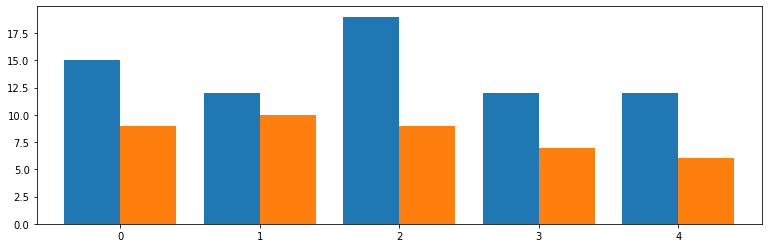

In [18]:
evaluate_ensemble(ensemble_models + (bin_ens,), test_dataset, valid_dataset)

In [19]:
train_dataset, test_dataset, valid_dataset = tfds.load(
    name='my_dataset', split=['train', 'test', 'valid'],
    data_dir='gs://tfds-gsc-1.appspot.com',
    as_supervised=True, try_gcs=True)
train_dataset.cardinality().numpy()

1095480

In [20]:
train_dataset = train_dataset.map(lambda x, y: (x[1:-1], y))
test_dataset  = test_dataset.map(lambda x, y:  (x[1:-1], y))
valid_dataset = valid_dataset.map(lambda x, y: (x[1:-1], y))

[[320, 295], [301, 289], [308, 299], [296, 290], [307, 293]]

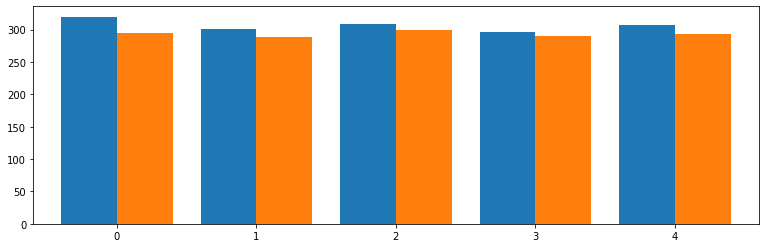

In [21]:
evaluate_ensemble(ensemble_models + (bin_ens,),
                  test_dataset.map(lambda x, y: [x, y < 10]),
                  valid_dataset.map(lambda x, y: [x, y < 10]))

In [22]:
ensemble_models = (
  (build_model, keras.layers.LeakyReLU, keras.layers.MaxPool1D, 12,     128),
  (build_model, keras.layers.ReLU,      keras.layers.AvgPool1D, 12,     128),
  (build_model, keras.layers.PReLU,     keras.layers.MaxPool1D, 12, 64, 128),
  (build_model, keras.layers.ELU,       keras.layers.AvgPool1D, 12, 64, 128),
)
ensemble_models = build_ensemble(builders=ensemble_models)

In [23]:
train_ensemble(ensemble_models, keras.losses.SparseCategoricalCrossentropy,
               train_dataset, valid_dataset)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Restoring model weights from 0330999035caff0857c7998701b3fb4f
Restoring model weights from 5c210ca4ea1921f02d4affec252ff827
Restoring model weights from 1f045c237a777366069d76eea98f072b
Restoring model weights from c5337e7f05c48df078a4c33b49a897e4


In [24]:
cat_ens = build_ensemble(models=ensemble_models, activation='softmax')

In [25]:
ensemble = build_ensemble(models=[bin_ens, cat_ens])
ensemble.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 47, 13)]     0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 12)           1657712     input_4[0][0]                    
__________________________________________________________________________________________________
model_5 (Functional)            (None, 1)            1652036     input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None,)              0           model_6[0][0]                    
____________________________________________________________________________________________

[[49, 28], [59, 23], [69, 26], [48, 20], [48, 19], [63, 30]]

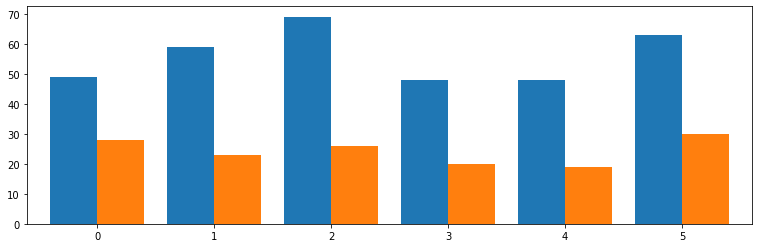

In [26]:
evaluate_ensemble(ensemble_models + (cat_ens, ensemble,),
                  test_dataset, valid_dataset)

In [27]:
matrix = tf.math.confusion_matrix(
  list(test_dataset.map(lambda x, y: y)),
  ensemble.predict(test_dataset.batch(4096)).argmax(axis=-1)).numpy()
for r in matrix:
  l = np.sum(r)
  for i in r:
    print(('%.2f' % (i / l)).replace('0.00', ' .  '), end = ' ')
  print("|", l)

0.99  .    .    .    .    .    .    .    .    .    .    .   | 315
 .   0.97  .    .    .    .    .    .    .   0.01 0.01  .   | 309
 .    .   0.99  .    .    .    .    .    .    .   0.01  .   | 304
 .    .    .   0.96  .    .    .    .   0.01  .   0.03  .   | 304
 .    .    .    .   0.98  .    .    .    .    .   0.02  .   | 310
 .    .    .    .    .   0.98  .    .    .    .   0.02  .   | 336
 .    .    .    .    .    .   0.99  .    .    .    .    .   | 249
 .    .    .    .    .    .    .   1.00  .    .    .    .   | 306
 .    .    .    .    .    .    .    .   0.99  .   0.01  .   | 298
 .    .    .    .    .    .    .    .    .   0.99 0.01  .   | 312
 .   0.01  .   0.01 0.01  .    .    .    .   0.01 0.96 0.01 | 365
 .    .    .    .    .    .    .    .    .    .    .   1.00 | 365


In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(ensemble)
tflite_model = converter.convert()
with open("2ecnn47.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa_tnp_ic/assets


INFO:tensorflow:Assets written to: /tmp/tmpa_tnp_ic/assets


In [29]:
!md5sum '2ecnn47.tflite'
!mv '2ecnn47.tflite' "$KERAS_MODELS_ABSOLUTE_PATH"

f69790f8c8ebcffacc14564f63a11490  2ecnn47.tflite
